In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#  Сравнение портфелей из криптовалют и акций

# **Ход работы**

Гипотеза:

За счет синергии с индексом NASDAQ портфель из компаний, которые связаны с криптовалютной индустрии, будут иметь большую доходность, чем портфель собранный из криптовалют



Цели работы:

1. Составить равновесные портфели из топ 5 криптовалют, на август 2020 года, и акицй компаний, которые были связаны с криптовалютной индустрии (т.е. занимались майнингом или просто держали криптовалюты на балансе на август 2020 года
2. Подсчитать и сравнить их доходность
3. Подсчитать их корреляцию

Этапы работы:


1. Обработка данных
2. Построение портфелей
3. Сравнение доходностей
4. Подсчет корреляции портфелей между собой и с индексой
5. Найти стандартное отклонение доходности и риск портфелей (VAR)

Бонус:

1. С помощью моделей машинного обучения построить прогноз доходностей портфелей на 2024 на год
2. Сравнить его с реальными данными

Итог работы:

Гипотеза оказалась подтвержденной

1) Фактическая доходность портфелей превышает их ожидаемую на рассматриваемом периоде (2020-2023)

2) Доходность портфелей положительно коррелирует между собой, оба портфеля коррелируют с индексом, но
корреляция портфеля из акций более выражена

3) По итогам расчета коэффициента Шарпа можно сказать, что портфель из криптовалют более эффективен, несмотря
на то, что показал меньшую доходность на рассматриваемом периоде

4) Портфель из акций криптовалют показывает значительно большую волатильность, что делает его более рисковым

5) Выбранные модели машинного обучения смогли спрогнозировать рост доходности, но не фактические значения

Отставание доходности портфеля криптовалют от портфеля акций можно объяснить тем, что из выбранных 5
криптовалют 2 значительно отставали в своем росте от общей капитализации криптовалютного рынка, BSV и BCH за
прошедшие 4 года потеряли позиции в топ-5 криптовалют по капитализации

# **Обработка данных**

In [ ]:
# Получаем исторические данные о котировках топ 5 криптовалют на момент августа 2020 с Yahoo Finance
#https://coinmarketcap.com/historical/20200801/ источник
crypto_data = yf.download(['BTC-USD', 'ETH-USD', 'XRP-USD','BCH-USD', 'BSV-USD'], start='2020-08-01', end='2024-01-01', interval='1d')

# Выводим данные о котировках BTC и ETH
# print(crypto_data)

[*********************100%%**********************]  5 of 5 completed


In [ ]:
crypto_data

Price        Adj Close                                                   \
Ticker         BCH-USD     BSV-USD       BTC-USD      ETH-USD   XRP-USD   
Date                                                                      
2020-08-01  317.996460  243.348358  11759.592773   385.199707  0.289529   
2020-08-02  283.781982  217.816162  11053.614258   370.671722  0.287062   
2020-08-03  296.535248  228.121796  11246.348633   386.295166  0.309940   
2020-08-04  288.385864  224.668747  11205.892578   389.875488  0.300493   
2020-08-05  294.486633  234.167892  11747.022461   401.590576  0.303311   
...                ...         ...           ...          ...       ...   
2023-12-27  264.086853   75.080704  43442.855469  2378.739990  0.634856   
2023-12-28  262.496643   91.545525  42627.855469  2347.566162  0.634998   
2023-12-29  254.512726   95.661629  42099.402344  2300.690674  0.623402   
2023-12-30  271.104340   93.416557  42156.902344  2292.065430  0.621844   
2023-12-31  259.262939   95.684090  42265.187500  2281.471191  0.614941   

Price            Close                                                   ...  \
Ticker         BCH-USD     BSV-USD       BTC-USD      ETH-USD   XRP-USD  ...   
Date                                                                     ...   
2020-08-01  317.996460  243.348358  11759.592773   385.199707  0.289529  ...   
2020-08-02  283.781982  217.816162  11053.614258   370.671722  0.287062  ...   
2020-08-03  296.535248  228.121796  11246.348633   386.295166  0.309940  ...   
2020-08-04  288.385864  224.668747  11205.892578   389.875488  0.300493  ...   
2020-08-05  294.486633  234.167892  11747.022461   401.590576  0.303311  ...   
...                ...         ...           ...          ...       ...  ...   
2023-12-27  264.086853   75.080704  43442.855469  2378.739990  0.634856  ...   
2023-12-28  262.496643   91.545525  42627.855469  2347.566162  0.634998  ...   
2023-12-29  254.512726   95.661629  42099.402344  2300.690674  0.623402  ...   
2023-12-30  271.104340   93.416557  42156.902344  2292.065430  0.621844  ...   
2023-12-31  259.262939   95.684090  42265.187500  2281.471191  0.614941  ...   

Price             Open                                                   \
Ticker         BCH-USD     BSV-USD       BTC-USD      ETH-USD   XRP-USD   
Date                                                                      
2020-08-01  300.504517  229.836899  11322.570312   345.798615  0.258904   
2020-08-02  318.419067  243.671234  11758.764648   385.549866  0.289742   
2020-08-03  283.911407  217.836243  11043.768555   371.133850  0.287490   
2020-08-04  296.531219  228.115112  11246.203125   386.156464  0.309935   
2020-08-05  288.384064  224.738358  11203.823242   389.710815  0.300783   
...                ...         ...           ...          ...       ...   
2023-12-27  229.173019   49.842735  42518.468750  2231.393066  0.622397   
2023-12-28  264.105957   75.069504  43468.199219  2380.200684  0.634948   
2023-12-29  262.453003   91.559296  42614.644531  2346.843750  0.635011   
2023-12-30  254.497910   95.637589  42091.753906  2300.399658  0.623411   
2023-12-31  271.072174   93.392380  42152.097656  2291.945312  0.621792   

Price           Volume                                                    
Ticker         BCH-USD     BSV-USD      BTC-USD      ETH-USD     XRP-USD  
Date                                                                      
2020-08-01  2447916240  2316011889  26075670303  14045259477  3167874461  
2020-08-02  3364496979  2677273031  27410067336  18909744275  4780736538  
2020-08-03  2060352679  1809758255  20271713443  12834648062  3340814994  
2020-08-04  1888924124  1718721505  21250197042  14086704221  2746437659  
2020-08-05  1871748593  1476218661  24411254471  12875466638  2048410252  
...                ...         ...          ...          ...         ...  
2023-12-27   596803711   372695915  25260941032  14161342927  1432931897  
2023-12-28   696442353   88

In [ ]:
# Загрузим данные по котировкам акций MSTR, MARA, RIOT
stocks_data = yf.download(['MSTR', 'MARA', 'RIOT', 'CLSK', 'HUT'], start='2020-08-01', end='2024-01-01', interval='1d')

# Выводим данные о котировках акций MSTR, MARA, RIOT
# print(stocks_data)

[*********************100%%**********************]  5 of 5 completed


In [ ]:
stocks_data

Price      Adj Close                                               Close  \
Ticker          CLSK        HUT       MARA        MSTR       RIOT   CLSK   
Date                                                                       
2020-08-03      6.55   4.700000   3.830000  123.660004   3.500000   6.55   
2020-08-04      6.79   4.700000   3.310000  123.320000   3.400000   6.79   
2020-08-05      6.99   4.975000   4.200000  123.949997   4.010000   6.99   
2020-08-06      7.87   4.710000   5.090000  123.349998   4.250000   7.87   
2020-08-07      9.19   4.495000   4.380000  123.389999   3.770000   9.19   
...              ...        ...        ...         ...        ...    ...   
2023-12-22     11.89  14.840000  26.709999  619.239990  17.780001  11.89   
2023-12-26     11.74  15.620000  26.959999  603.890015  17.350000  11.74   
2023-12-27     13.43  18.125000  31.070000  670.710022  18.620001  13.43   
2023-12-28     13.11  16.129999  28.110001  667.880005  17.600000  13.11   
2023-12-29     11.03  13.340000  23.490000  631.619995  15.470000  11.03   

Price                                                    ...   Open  \
Ticker            HUT       MARA        MSTR       RIOT  ...   CLSK   
Date                                                     ...          
2020-08-03   4.700000   3.830000  123.660004   3.500000  ...   7.20   
2020-08-04   4.700000   3.310000  123.320000   3.400000  ...   6.87   
2020-08-05   4.975000   4.200000  123.949997   4.010000  ...   6.90   
2020-08-06   4.710000   5.090000  123.349998   4.250000  ...   7.00   
2020-08-07   4.495000   4.380000  123.389999   3.770000  ...   8.01   
...               ...        ...         ...        ...  ...    ...   
2023-12-22  14.840000  26.709999  619.239990  17.780001  ...  11.66   
2023-12-26  15.620000  26.959999  603.890015  17.350000  ...  11.69   
2023-12-27  18.125000  31.070000  670.710022  18.620001  ...  12.26   
2023-12-28  16.129999  28.110001  667.880005  17.600000  ...  12.66   
2023-12-29  13.340000  23.490000  631.619995  15.470000  ...  13.20   

Price                                                      Volume            \
Ticker            HUT       MARA        MSTR       RIOT      CLSK       HUT   
Date                                                                          
2020-08-03   4.375000   3.110000  124.370003   2.900000   4305600     75300   
2020-08-04   4.920000   3.010000  123.120003   3.200000   2326400     30200   
2020-08-05   5.050000   4.200000  124.110001   4.070000   2104300     61540   
2020-08-06   4.895000   4.500000  123.800003   4.370000   3880000     49680   
2020-08-07   4.600000   4.550000  123.000000   4.120000   7628600     36820   
...               ...        ...         ...        ...       ...       ...   
2023-12-22  13.280000  25.520000  581.960022  16.750000  27396200  12831100   
2023-12-26  14.740000  26.150000  609.489990  17.430000  22123700   9311400   
2023-12-27  16.049999  28.150000  613.799988  17.900000  27394000  12996700   
2023-12-28  17.049999  28.990000  654.690002  18.209999  25965600  14097300   
2023-12-29  16.400000  28.950001  674.830017  17.870001  35889100  18583200   

Price                                     
Ticker           MARA     MSTR      RIOT  
Date                                      
2020-08-03  225520800    52600  58695600  
2020-08-04   28945700    50200  14269800  
2020-08-05   97988400    52300  39590900  
2020-08-06   80517400    34800  27231000  
2020-08-07   27004100    37000  14748700  
...               ...      ...       ...  
2023-12-22  118192600  1255900  45369800  
2023-12-26   79566200  1204700  30645300  
2023-12-27  106789700  2127300  43092600  
2023-12-28  119982200  1580800  45018800  
2023-12-29  144398300  1579000  58587700  

[859 rows x 30 columns]

In [ ]:
# Используем Индекс NASDAQ как эталон рыночной доходности

NASDAQ_data = yf.download('^IXIC', start='2020-08-01', end='2024-01-01', interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
NASDAQ_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-08-03,10848.639648,10927.559570,10831.150391,10902.799805,10902.799805,4203890000
2020-08-04,10897.889648,10941.910156,10852.900391,10941.169922,10941.169922,4016520000
2020-08-05,10967.870117,11002.110352,10943.719727,10998.400391,10998.400391,4160740000
2020-08-06,10989.980469,11121.190430,10963.410156,11108.070312,11108.070312,4120000000
2020-08-07,11072.530273,11126.040039,10920.370117,11010.980469,11010.980469,4263930000
...,...,...,...,...,...,...
2023-12-22,15006.179688,15047.190430,14927.120117,14992.969727,14992.969727,4796600000
2023-12-26,15028.690430,15101.179688,15024.059570,15074.570312,15074.570312,6120600000
2023-12-27,15089.660156,15114.080078,15051.669922,15099.179688,15099.179688,7480170000


Даты не совпадают, берем лишь те даты, которые есть в данных о акциях

In [ ]:
# Получаем список торговых дней из stocks_data
stock_trading_days = stocks_data.index

# Фильтруем crypto_data, оставляя только строки с торговыми днями из stocks_data
crypto_data_filtered = crypto_data[crypto_data.index.isin(stock_trading_days)]


# print(crypto_data_filtered)
# Проверяем размер
print(len(crypto_data_filtered), len(stocks_data), len(NASDAQ_data))

859 859 859


In [ ]:
NASDAQ_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
# Убираем лишние данные с ценом, считаем по закрытию дня
crypto_data_filtered = crypto_data_filtered[[(    'Close', 'BCH-USD'),
            (    'Close', 'BSV-USD'),
            (    'Close', 'BTC-USD'),
            (    'Close', 'ETH-USD'),
            (    'Close', 'XRP-USD')]]

stocks_data = stocks_data[[(    'Close', 'CLSK'),
            (    'Close',  'HUT'),
            (    'Close', 'MARA'),
            (    'Close', 'MSTR'),
            (    'Close', 'RIOT')]]

NASDAQ_data = NASDAQ_data[['Close', 'Volume']]

In [ ]:
NASDAQ_data.info

<bound method DataFrame.info of                    Close      Volume
Date                                
2020-08-03  10902.799805  4203890000
2020-08-04  10941.169922  4016520000
2020-08-05  10998.400391  4160740000
2020-08-06  11108.070312  4120000000
2020-08-07  11010.980469  4263930000
...                  ...         ...
2023-12-22  14992.969727  4796600000
2023-12-26  15074.570312  6120600000
2023-12-27  15099.179688  7480170000
2023-12-28  15095.139648  5090570000
2023-12-29  15011.349609  5441060000

[859 rows x 2 columns]>

Задаем столбец изменения цены

In [ ]:
# #абсолютное изменение цены

# crypto_data_filtered['Price Change', 'BCH-USD'] = crypto_data_filtered['Close', 'BCH-USD'] - crypto_data_filtered['Close', 'BCH-USD'].shift(1)
# crypto_data_filtered['Price Change', 'BSV-USD'] = crypto_data_filtered['Close', 'BSV-USD'] - crypto_data_filtered['Close', 'BSV-USD'].shift(1)
# crypto_data_filtered['Price Change', 'BTC-USD'] = crypto_data_filtered['Close', 'BTC-USD'] - crypto_data_filtered['Close', 'BTC-USD'].shift(1)
# crypto_data_filtered['Price Change', 'ETH-USD'] = crypto_data_filtered['Close', 'ETH-USD'] - crypto_data_filtered['Close', 'ETH-USD'].shift(1)
# crypto_data_filtered['Price Change', 'XRP-USD'] = crypto_data_filtered['Close', 'XRP-USD'] - crypto_data_filtered['Close', 'XRP-USD'].shift(1)

# # тоже самое для stocks_data
# stocks_data['Price Change', 'CLSK'] = stocks_data['Close', 'CLSK'] - stocks_data['Close', 'CLSK'].shift(1)
# stocks_data['Price Change', 'HUT'] = stocks_data['Close', 'HUT'] - stocks_data['Close', 'HUT'].shift(1)
# stocks_data['Price Change', 'MARA'] = stocks_data['Close', 'MARA'] - stocks_data['Close', 'MARA'].shift(1)
# stocks_data['Price Change', 'MSTR'] = stocks_data['Close', 'MSTR'] - stocks_data['Close', 'MSTR'].shift(1)
# stocks_data['Price Change', 'RIOT'] = stocks_data['Close', 'RIOT'] - stocks_data['Close', 'RIOT'].shift(1)

In [ ]:
# Для криптовалютных данных
crypto_data_filtered['Price Change', 'BCH-USD'] = (crypto_data_filtered['Close', 'BCH-USD'] - crypto_data_filtered['Close', 'BCH-USD'].shift(1)) / crypto_data_filtered['Close', 'BCH-USD'].shift(1)
crypto_data_filtered['Price Change', 'BSV-USD'] = (crypto_data_filtered['Close', 'BSV-USD'] - crypto_data_filtered['Close', 'BSV-USD'].shift(1)) / crypto_data_filtered['Close', 'BSV-USD'].shift(1)
crypto_data_filtered['Price Change', 'BTC-USD'] = (crypto_data_filtered['Close', 'BTC-USD'] - crypto_data_filtered['Close', 'BTC-USD'].shift(1)) / crypto_data_filtered['Close', 'BTC-USD'].shift(1)
crypto_data_filtered['Price Change', 'ETH-USD'] = (crypto_data_filtered['Close', 'ETH-USD'] - crypto_data_filtered['Close', 'ETH-USD'].shift(1)) / crypto_data_filtered['Close', 'ETH-USD'].shift(1)
crypto_data_filtered['Price Change', 'XRP-USD'] = (crypto_data_filtered['Close', 'XRP-USD'] - crypto_data_filtered['Close', 'XRP-USD'].shift(1)) / crypto_data_filtered['Close', 'XRP-USD'].shift(1)

# Для акций
stocks_data['Price Change', 'CLSK'] = (stocks_data['Close', 'CLSK'] - stocks_data['Close', 'CLSK'].shift(1)) / stocks_data['Close', 'CLSK'].shift(1)
stocks_data['Price Change', 'HUT'] = (stocks_data['Close', 'HUT'] - stocks_data['Close', 'HUT'].shift(1)) / stocks_data['Close', 'HUT'].shift(1)
stocks_data['Price Change', 'MARA'] = (stocks_data['Close', 'MARA'] - stocks_data['Close', 'MARA'].shift(1)) / stocks_data['Close', 'MARA'].shift(1)
stocks_data['Price Change', 'MSTR'] = (stocks_data['Close', 'MSTR'] - stocks_data['Close', 'MSTR'].shift(1)) / stocks_data['Close', 'MSTR'].shift(1)
stocks_data['Price Change', 'RIOT'] = (stocks_data['Close', 'RIOT'] - stocks_data['Close', 'RIOT'].shift(1)) / stocks_data['Close', 'RIOT'].shift(1)

#Для индекса

NASDAQ_data['Index Change'] = (NASDAQ_data['Close'] - NASDAQ_data['Close'].shift(1)) / NASDAQ_data['Close'].shift(1)

<ipython-input-25-a099e891286d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_data['Price Change', 'CLSK'] = (stocks_data['Close', 'CLSK'] - stocks_data['Close', 'CLSK'].shift(1)) / stocks_data['Close', 'CLSK'].shift(1)
<ipython-input-25-a099e891286d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_data['Price Change', 'HUT'] = (stocks_data['Close', 'HUT'] - stocks_data['Close', 'HUT'].shift(1)) / stocks_data['Close', 'HUT'].shift(1)
<ipython-input-25-a099e891286d>:11: SettingWithCopyWarn

In [ ]:
# Заменить все NaN на 0 в crypto_data_filtered
crypto_data_filtered = crypto_data_filtered.fillna(0)

# Заменить все NaN на 0 в stocks_data
stocks_data = stocks_data.fillna(0)

# Заменить все NaN на 0 в NASDAQ_data
NASDAQ_data = NASDAQ_data.fillna(0)

In [ ]:
stocks_data


Price       Close                                              Price Change  \
Ticker       CLSK        HUT       MARA        MSTR       RIOT         CLSK   
Date                                                                          
2020-08-03   6.55   4.700000   3.830000  123.660004   3.500000     0.000000   
2020-08-04   6.79   4.700000   3.310000  123.320000   3.400000     0.036641   
2020-08-05   6.99   4.975000   4.200000  123.949997   4.010000     0.029455   
2020-08-06   7.87   4.710000   5.090000  123.349998   4.250000     0.125894   
2020-08-07   9.19   4.495000   4.380000  123.389999   3.770000     0.167726   
...           ...        ...        ...         ...        ...          ...   
2023-12-22  11.89  14.840000  26.709999  619.239990  17.780001     0.031223   
2023-12-26  11.74  15.620000  26.959999  603.890015  17.350000    -0.012616   
2023-12-27  13.43  18.125000  31.070000  670.710022  18.620001     0.143952   
2023-12-28  13.11  16.129999  28.110001  667.880005  17.600000    -0.023827   
2023-12-29  11.03  13.340000  23.490000  631.619995  15.470000    -0.158658   

Price                                               
Ticker           HUT      MARA      MSTR      RIOT  
Date                                                
2020-08-03  0.000000  0.000000  0.000000  0.000000  
2020-08-04  0.000000 -0.135770 -0.002750 -0.028571  
2020-08-05  0.058511  0.268882  0.005109  0.179412  
2020-08-06 -0.053266  0.211905 -0.004841  0.059850  
2020-08-07 -0.045648 -0.139489  0.000324 -0.112941  
...              ...       ...       ...       ...  
2023-12-22  0.133690  0.077885  0.064078  0.061493  
2023-12-26  0.052561  0.009360 -0.024788 -0.024184  
2023-12-27  0.160371  0.152448  0.110649  0.073199  
2023-12-28 -0.110069 -0.095269 -0.004219 -0.054780  
2023-12-29 -0.172970 -0.164354 -0.054291 -0.121023  

[859 rows x 10 columns]

# **Построение портфелей**

Создаем два равновесных портфеля

In [ ]:
# # Создаем датафрейм для равновесного портфеля криптовалют
# equal_crypto_portfolio = pd.DataFrame()
# equal_crypto_portfolio['Price Change CP'] = 0.2 * crypto_data_filtered['Price Change', 'BCH-USD'] + \
#                                             0.2 * crypto_data_filtered['Price Change', 'BSV-USD'] + \
#                                             0.2 * crypto_data_filtered['Price Change', 'BTC-USD'] + \
#                                             0.2 * crypto_data_filtered['Price Change', 'ETH-USD'] + \
#                                             0.2 * crypto_data_filtered['Price Change', 'XRP-USD']

# # Создаем датафрейм для равновесного портфеля акций
# equal_stocks_portfolio = pd.DataFrame()
# equal_stocks_portfolio['Price Change SP'] = 0.2 * stocks_data['Price Change', 'CLSK'] + \
#                                             0.2 * stocks_data['Price Change', 'HUT'] + \
#                                             0.2 * stocks_data['Price Change', 'MARA'] + \
#                                             0.2 * stocks_data['Price Change', 'MSTR'] + \
#                                             0.2 * stocks_data['Price Change', 'RIOT']

In [ ]:
# Создаем датафрейм для равновесных портфелей криптовалют и акций
equal_portfolio = pd.DataFrame()
equal_portfolio['Price Change Crypto'] = 0.2 * crypto_data_filtered['Price Change', 'BCH-USD'] + \
                                            0.2 * crypto_data_filtered['Price Change', 'BSV-USD'] + \
                                            0.2 * crypto_data_filtered['Price Change', 'BTC-USD'] + \
                                            0.2 * crypto_data_filtered['Price Change', 'ETH-USD'] + \
                                            0.2 * crypto_data_filtered['Price Change', 'XRP-USD']

# Создаем датафрейм для равновесного портфеля акций
equal_portfolio['Price Change Stocks'] = 0.2 * stocks_data['Price Change', 'CLSK'] + \
                                            0.2 * stocks_data['Price Change', 'HUT'] + \
                                            0.2 * stocks_data['Price Change', 'MARA'] + \
                                            0.2 * stocks_data['Price Change', 'MSTR'] + \
                                            0.2 * stocks_data['Price Change', 'RIOT']

equal_portfolio['Index Change']  = NASDAQ_data['Index Change']


In [ ]:
equal_portfolio

,Price Change Crypto,Price Change Stocks,Index Change
Date,,,
2020-08-03,0.000000,0.000000,0.000000
2020-08-04,-0.013486,-0.026090,0.003519
2020-08-05,0.030230,0.108274,0.005231
2020-08-06,0.009210,0.067908,0.009971
2020-08-07,-0.026604,-0.026006,-0.008740
...,...,...,...
2023-12-22,0.018815,0.073674,0.001945
2023-12-26,-0.028046,0.000066,0.005443
2023-12-27,0.153325,0.128124,0.001633


# **Сравнение доходности портфелей**

In [ ]:
# Крипта

expected_return_BCH = 100*crypto_data_filtered['Price Change', 'BCH-USD'].mean() * len(crypto_data_filtered)
expected_return_BSV = 100*crypto_data_filtered['Price Change', 'BSV-USD'].mean() * len(crypto_data_filtered)
expected_return_BTC = 100*crypto_data_filtered['Price Change', 'BTC-USD'].mean() * len(crypto_data_filtered)
expected_return_ETH = 100*crypto_data_filtered['Price Change', 'ETH-USD'].mean() * len(crypto_data_filtered)
expected_return_XRP = 100*crypto_data_filtered['Price Change', 'XRP-USD'].mean() * len(crypto_data_filtered)

# Акции

expected_return_CLSK= 100*stocks_data['Price Change', 'CLSK'].mean() * len(stocks_data)
expected_return_HUT = 100*stocks_data['Price Change', 'HUT'].mean() * len(stocks_data)
expected_return_MARA = 100*stocks_data['Price Change', 'MARA'].mean() * len(stocks_data)
expected_return_MSTR = 100*stocks_data['Price Change', 'MSTR'].mean() * len(stocks_data)
expected_return_RIOT = 100*stocks_data['Price Change', 'RIOT'].mean() * len(stocks_data)

expected_return_Index = round(100*NASDAQ_data['Index Change'].mean() * len(NASDAQ_data),2)


# Вывод доходностей

print('Ожидаемая доходность BCH:', expected_return_BCH, '%')
print('Ожидаемая доходность BSV:', expected_return_BSV, '%')
print('Ожидаемая доходность BTC:', expected_return_BTC, '%')
print('Ожидаемая доходность ETH:', expected_return_ETH, '%')
print('Ожидаемая доходность XRP:', expected_return_XRP, '%')

print('')

print('Ожидаемая доходность CLSK:', expected_return_CLSK, '%')
print('Ожидаемая доходность HUT:', expected_return_HUT, '%')
print('Ожидаемая доходность MARA:', expected_return_MARA, '%')
print('Ожидаемая доходность MSTR:', expected_return_MSTR, '%')
print('Ожидаемая доходность RIOT:', expected_return_RIOT, '%')

print('')

print('Ожидаемая доходность индекса NASDAQ:', expected_return_Index, '%')


#Для портфелей

expected_return_crypto_portfolio = round(100*equal_portfolio['Price Change Crypto'].mean() * len(equal_portfolio),2)
expected_return_stocks_portfolio = round(100*equal_portfolio['Price Change Stocks'].mean() * len(equal_portfolio),2)
expected_return_index_portfolio = 100*equal_portfolio['Index Change'].mean() * len(equal_portfolio)

print('')


print('Ожидаемая доходность в портфеле криптовалют:', expected_return_crypto_portfolio, '%')

print('')

print('Ожидаемая доходность в портфеле акций:', expected_return_stocks_portfolio, '%')
# print('Ожидаемая доходность индекса:', expected_return_index_portfolio)

Ожидаемая доходность BCH: 138.91524081748045 %
Ожидаемая доходность BSV: 68.9882570266451 %
Ожидаемая доходность BTC: 201.9368755530128 %
Ожидаемая доходность ETH: 303.944242069652 %
Ожидаемая доходность XRP: 296.3809334945983 %

Ожидаемая доходность CLSK: 251.8168899942352 %
Ожидаемая доходность HUT: 340.1861572623664 %
Ожидаемая доходность MARA: 478.1017962125729 %
Ожидаемая доходность MSTR: 308.5583465107867 %
Ожидаемая доходность RIOT: 378.4445307693969 %

Ожидаемая доходность индекса NASDAQ: 41.29 %

Ожидаемая доходность в портфеле криптовалют: 202.03 %

Ожидаемая доходность в портфеле акций: 351.42 %


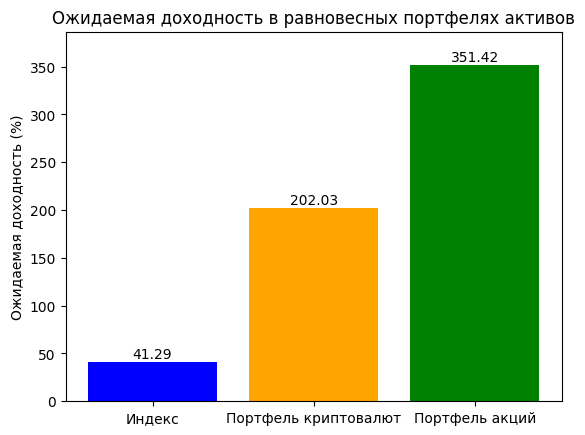

In [ ]:
# Список для имен портфелей
portfolios = ['Индекс', 'Портфель криптовалют', 'Портфель акций']

# Список для значений доходности
returns = [expected_return_Index, expected_return_crypto_portfolio, expected_return_stocks_portfolio]

# Построение столбчатой диаграммы
plt.bar(portfolios, returns, color=['blue', 'orange', 'green'])
plt.ylabel('Ожидаемая доходность (%)')
plt.title('Ожидаемая доходность в равновесных портфелях активов')
plt.ylim(0, max(returns) * 1.1)  # Настройка пределов по оси Y

# Вывод значений над столбцами
for i in range(len(portfolios)):
    plt.text(i, returns[i] + 0.5, str(returns[i]), ha='center', va='bottom')

plt.show()

# **Корреляция**

In [ ]:
# Вычисляем корреляцию между каждым столбцом
correlation_crypto_stocks = equal_portfolio['Price Change Crypto'].corr(equal_portfolio['Price Change Stocks'])
correlation_crypto_index = equal_portfolio['Price Change Crypto'].corr(equal_portfolio['Index Change'])
correlation_stocks_index = equal_portfolio['Price Change Stocks'].corr(equal_portfolio['Index Change'])

# Выводим результат
print(f'Корреляция между Price Change Crypto и Price Change Stocks: {correlation_crypto_stocks}')
print(f'Корреляция между Price Change Crypto и Index Change: {correlation_crypto_index}')
print(f'Корреляция между Price Change Stocks и Index Change: {correlation_stocks_index}')

Корреляция между Price Change Crypto и Price Change Stocks: 0.5849549075600421
Корреляция между Price Change Crypto и Index Change: 0.3486485906421587
Корреляция между Price Change Stocks и Index Change: 0.5709963162971162


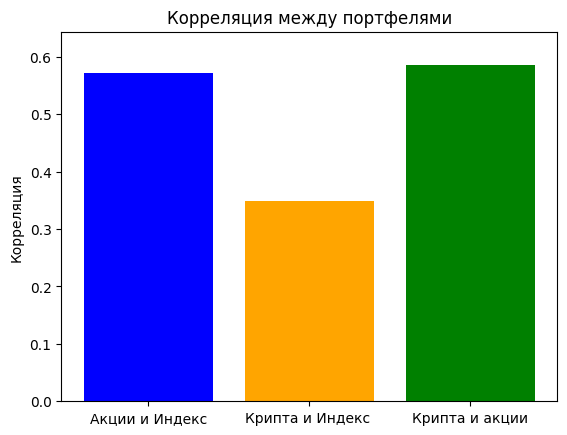

In [ ]:
corrs_name = ['Крипта и акции', 'Крипта и Индекс ', 'Акции и Индекс']
corrs = [correlation_crypto_stocks, correlation_crypto_index, correlation_stocks_index]

corrs_name.reverse()
corrs.reverse()

# Построение столбчатой диаграммы
plt.bar(corrs_name, corrs, color=['blue', 'orange', 'green'])
plt.ylabel('Корреляция')
plt.title('Корреляция между портфелями')
plt.ylim(0, max(corrs) * 1.1)  # Настройка пределов по оси Y

# # Вывод значений над столбцами
# for i in range(len(corrs_name)):
#     plt.text(i, corrs[i] + 0.5, str(corrs[i]), ha='center', va='bottom')

plt.show()


# **Нахождение стандартного отклонения доходности и коэффициента Шарпа**


In [ ]:
#Сначала создаем массив данных для вычисления стандартного отклонения каждой колонки
data = np.array([equal_portfolio['Price Change Crypto'], equal_portfolio['Price Change Stocks'], equal_portfolio['Index Change']])

# Вычисляем стандартное отклонение для каждой колонки
std_dev_crypto = np.std(data[0])
std_dev_stocks = np.std(data[1])
std_dev_index = np.std(data[2])

# Выводим результат
print(f"Дневное стандартное отклонение Price Change Crypto: {round((std_dev_crypto*100),2)}%")
print(f"Дневное стандартное отклонение Price Change Stocks: {round((std_dev_stocks*100),2)}%")
print(f"Дневное стандартное отклонение Index Change: {round((std_dev_index*100),2)}%")

Дневное стандартное отклонение Price Change Crypto: 4.79%
Дневное стандартное отклонение Price Change Stocks: 6.27%
Дневное стандартное отклонение Index Change: 1.47%


In [ ]:
#Отклонение доходности = стандартное отклонение цены портфеля*корень(числа дней)
#В нашем случае это (len(equal_portfolio)**0.5)

# Выводим результат
print(f"Стандартное отклонение доходности Price Change Crypto: {round((std_dev_crypto*100*(len(equal_portfolio)**0.5)),2)}%")
print(f"Стандартное отклонение доходности Price Change Stocks: {round((std_dev_stocks*100*(len(equal_portfolio)**0.5)),2)}%")
print(f"Стандартное отклонение доходности Index Change: {round((std_dev_index*100*(len(equal_portfolio)**0.5)),2)}%")

Стандартное отклонение доходности Price Change Crypto: 140.37%
Стандартное отклонение доходности Price Change Stocks: 183.62%
Стандартное отклонение доходности Index Change: 43.11%


In [ ]:
#Коэффициент Шарпа
#Безрисковая доходность принята за 5%

coef_sharp_crypto = (expected_return_crypto_portfolio-5)/(std_dev_crypto*100*(len(equal_portfolio)**0.5))
coef_sharp_stocks = (expected_return_crypto_portfolio-5)/(std_dev_stocks*100*(len(equal_portfolio)**0.5))

print('Для портфеля криптовалют коэффициент Шарпа:', coef_sharp_crypto)
print('Для портфеля аций коэффициент Шарпа:', coef_sharp_stocks)

Для портфеля криптовалют коэффициент Шарпа: 1.4036250728372592
Для портфеля аций коэффициент Шарпа: 1.073030373576763


# **Нахождение рисков портфелей**


In [ ]:
data = np.array([crypto_data_filtered['Price Change', 'BCH-USD'], crypto_data_filtered['Price Change', 'BSV-USD'], crypto_data_filtered['Price Change', 'BTC-USD'], crypto_data_filtered['Price Change', 'ETH-USD'], crypto_data_filtered['Price Change', 'XRP-USD']])

# Вычисляем стандартное отклонение для каждой колонки
std_dev_BCH = np.std(data[0])
std_dev_BSV = np.std(data[1])
std_dev_BTC = np.std(data[2])
std_dev_ETH = np.std(data[3])
std_dev_XRP = np.std(data[4])

# Выводим результат
print(f"Дневное стандартное отклонение Price Change BCH-USD: {round((std_dev_BCH*100),2)}%")
print(f"Дневное стандартное отклонение Price Change BSV-USD: {round((std_dev_BSV*100),2)}%")
print(f"Дневное стандартное отклонение Price Change BTC-USD: {round((std_dev_BTC*100),2)}%")
print(f"Дневное стандартное отклонение Price Change ETH-USD: {round((std_dev_ETH*100),2)}%")
print(f"Дневное стандартное отклонение Price Change XRP-USD: {round((std_dev_XRP*100),2)}%")

Дневное стандартное отклонение Price Change BCH-USD: 6.05%
Дневное стандартное отклонение Price Change BSV-USD: 6.07%
Дневное стандартное отклонение Price Change BTC-USD: 4.03%
Дневное стандартное отклонение Price Change ETH-USD: 5.42%
Дневное стандартное отклонение Price Change XRP-USD: 7.65%


In [ ]:
# Выводим результат

otkBCH = std_dev_BCH*100*(len(equal_portfolio)**0.5)*0.2
otkBSV = std_dev_BSV*100*(len(equal_portfolio)**0.5)*0.2
otkBTC = std_dev_BTC*100*(len(equal_portfolio)**0.5)*0.2
otkETH = std_dev_ETH*100*(len(equal_portfolio)**0.5)*0.2
otkXRP = std_dev_XRP*100*(len(equal_portfolio)**0.5)*0.2

print(f"Cтандартное отклонение доходности Price Change BCH-USD: {round((std_dev_BCH*100*(len(equal_portfolio)**0.5)),2)}%")
print(f"Cтандартное отклонение доходности Price Change BSV-USD: {round((std_dev_BSV*100*(len(equal_portfolio)**0.5)),2)}%")
print(f"Cтандартное отклонение доходности Price Change BTC-USD: {round((std_dev_BTC*100*(len(equal_portfolio)**0.5)),2)}%")
print(f"Cтандартное отклонение доходности Price Change ETH-USD: {round((std_dev_ETH*100*(len(equal_portfolio)**0.5)),2)}%")
print(f"Cтандартное отклонение доходности Price Change XRP-USD: {round((std_dev_XRP*100*(len(equal_portfolio)**0.5)),2)}%")

Cтандартное отклонение доходности Price Change BCH-USD: 177.46%
Cтандартное отклонение доходности Price Change BSV-USD: 177.91%
Cтандартное отклонение доходности Price Change BTC-USD: 118.04%
Cтандартное отклонение доходности Price Change ETH-USD: 158.84%
Cтандартное отклонение доходности Price Change XRP-USD: 224.32%


In [ ]:
# Создаем список с названиями колонок
columns = ['BCH-USD', 'BSV-USD', 'BTC-USD', 'ETH-USD', 'XRP-USD']

# Проходим по всем парам колонок и рассчитываем корреляцию
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = 'Price Change', columns[i]
        col2 = 'Price Change', columns[j]
        correlation = crypto_data_filtered[col1].corr(crypto_data_filtered[col2])
        print(f"Корреляция между {col1} и {col2}: {correlation}")



Корреляция между ('Price Change', 'BCH-USD') и ('Price Change', 'BSV-USD'): 0.76078257566848
Корреляция между ('Price Change', 'BCH-USD') и ('Price Change', 'BTC-USD'): 0.6953838646649939
Корреляция между ('Price Change', 'BCH-USD') и ('Price Change', 'ETH-USD'): 0.692632403714691
Корреляция между ('Price Change', 'BCH-USD') и ('Price Change', 'XRP-USD'): 0.4976768838860724
Корреляция между ('Price Change', 'BSV-USD') и ('Price Change', 'BTC-USD'): 0.5753381704984011
Корреляция между ('Price Change', 'BSV-USD') и ('Price Change', 'ETH-USD'): 0.5848641587373766
Корреляция между ('Price Change', 'BSV-USD') и ('Price Change', 'XRP-USD'): 0.4444183375793373
Корреляция между ('Price Change', 'BTC-USD') и ('Price Change', 'ETH-USD'): 0.7865447758397849
Корреляция между ('Price Change', 'BTC-USD') и ('Price Change', 'XRP-USD'): 0.46455263820888676
Корреляция между ('Price Change', 'ETH-USD') и ('Price Change', 'XRP-USD'): 0.5241860512766667


In [ ]:
#риск портфеля криптовалют


risk_crypto = 0.2*otkBCH + 0.2*otkBSV + 0.2*otkBTC+ 0.2*otkETH + 0.2*otkXRP+0.2*0.2*otkBCH*otkBSV*0.76+0.2*0.2*otkBCH*otkBTC*0.695+0.2*0.2*otkBCH*otkETH*0.692+0.2*0.2*otkBCH*otkXRP*0.497+0.2*0.2*otkBSV*otkBTC*0.575+0.2*0.2*otkBSV*otkETH*0.584+0.2*0.2*otkBSV*otkXRP*0.444+0.2*0.2*otkBTC*otkETH*0.786+0.2*0.2*otkBTC*otkXRP*0.464+0.2*0.2*otkETH*otkXRP*0.524

In [ ]:
print('Риск портфеля криптовалют:', risk_crypto, risk_crypto**0.5)

Риск портфеля криптовалют: 305.9977806129632 17.49279224746476


Риск портфеля криптовалют: 17.49%

In [ ]:
data = np.array([stocks_data['Price Change', 'CLSK'], stocks_data['Price Change', 'HUT'], stocks_data['Price Change', 'MARA'], stocks_data['Price Change', 'MSTR'], stocks_data['Price Change', 'RIOT']])

# Вычисляем стандартное отклонение для каждой колонки
std_dev_CLSK = np.std(data[0])
std_dev_HUT = np.std(data[1])
std_dev_MARA = np.std(data[2])
std_dev_MSTR = np.std(data[3])
std_dev_RIOT = np.std(data[4])

# Выводим результат
print(f"Дневное стандартное отклонение Price Change CLSK: {round((std_dev_CLSK*100),2)}%")
print(f"Дневное стандартное отклонение Price Change HUT: {round((std_dev_HUT*100),2)}%")
print(f"Дневное стандартное отклонение Price Change MARA: {round((std_dev_MARA*100),2)}%")
print(f"Дневное стандартное отклонение Price Change MSTR: {round((std_dev_MSTR*100),2)}%")
print(f"Дневное стандартное отклонение Price Change RIOT: {round((std_dev_RIOT*100),2)}%")

Дневное стандартное отклонение Price Change CLSK: 6.9%
Дневное стандартное отклонение Price Change HUT: 7.56%
Дневное стандартное отклонение Price Change MARA: 8.5%
Дневное стандартное отклонение Price Change MSTR: 5.82%
Дневное стандартное отклонение Price Change RIOT: 7.47%


In [ ]:
otkCLSK = std_dev_CLSK * 100 * (len(equal_portfolio) ** 0.5) * 0.2
otkHUT = std_dev_HUT * 100 * (len(equal_portfolio) ** 0.5) * 0.2
otkMARA = std_dev_MARA * 100 * (len(equal_portfolio) ** 0.5) * 0.2
otkMSTR = std_dev_MSTR * 100 * (len(equal_portfolio) ** 0.5) * 0.2
otkRIOT = std_dev_RIOT * 100 * (len(equal_portfolio) ** 0.5) * 0.2

print(f"Cтандартное отклонение доходности Price Change CLSK: {round((std_dev_CLSK * 100 * (len(equal_portfolio) ** 0.5)), 2)}%")
print(f"Cтандартное отклонение доходности Price Change HUT: {round((std_dev_HUT * 100 * (len(equal_portfolio) ** 0.5)), 2)}%")
print(f"Cтандартное отклонение доходности Price Change MARA: {round((std_dev_MARA * 100 * (len(equal_portfolio) ** 0.5)), 2)}%")
print(f"Cтандартное отклонение доходности Price Change MSTR: {round((std_dev_MSTR * 100 * (len(equal_portfolio) ** 0.5)), 2)}%")
print(f"Cтандартное отклонение доходности Price Change RIOT: {round((std_dev_RIOT * 100 * (len(equal_portfolio) ** 0.5)), 2)}%")

Cтандартное отклонение доходности Price Change CLSK: 202.35%
Cтандартное отклонение доходности Price Change HUT: 221.64%
Cтандартное отклонение доходности Price Change MARA: 249.07%
Cтандартное отклонение доходности Price Change MSTR: 170.63%
Cтандартное отклонение доходности Price Change RIOT: 219.03%


In [ ]:
# Создаем список с названиями колонок
columns = ['CLSK', 'HUT', 'MARA', 'MSTR', 'RIOT']

# Проходим по всем парам колонок и рассчитываем ковариацию
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = 'Price Change', columns[i]
        col2 = 'Price Change', columns[j]
        covariance = stocks_data[col1].corr(stocks_data[col2])
        print(f"Корреляция между {col1} и {col2}: {covariance}")

Корреляция между ('Price Change', 'CLSK') и ('Price Change', 'HUT'): 0.5466572624489912
Корреляция между ('Price Change', 'CLSK') и ('Price Change', 'MARA'): 0.6049471201983221
Корреляция между ('Price Change', 'CLSK') и ('Price Change', 'MSTR'): 0.5741135984257245
Корреляция между ('Price Change', 'CLSK') и ('Price Change', 'RIOT'): 0.6034797485770517
Корреляция между ('Price Change', 'HUT') и ('Price Change', 'MARA'): 0.7557734105044804
Корреляция между ('Price Change', 'HUT') и ('Price Change', 'MSTR'): 0.6709600732445278
Корреляция между ('Price Change', 'HUT') и ('Price Change', 'RIOT'): 0.724319787892986
Корреляция между ('Price Change', 'MARA') и ('Price Change', 'MSTR'): 0.6960871546217163
Корреляция между ('Price Change', 'MARA') и ('Price Change', 'RIOT'): 0.8516620375292877
Корреляция между ('Price Change', 'MSTR') и ('Price Change', 'RIOT'): 0.7217710532184903


In [ ]:
risk_stocks = 0.2*otkCLSK + 0.2*otkHUT + 0.2*otkMARA + 0.2*otkMSTR + 0.2*otkRIOT + 0.2*0.2*otkCLSK*otkHUT*0.546 + 0.2*0.2*otkCLSK*otkMARA*0.604 + 0.2*0.2*otkCLSK*otkMSTR*0.574 + 0.2*0.2*otkCLSK*otkRIOT*0.603 + 0.2*0.2*otkHUT*otkMARA*0.755 + 0.2*0.2*otkHUT*otkMSTR*0.671 + 0.2*0.2*otkHUT*otkRIOT*0.724 + 0.2*0.2*otkMARA*otkMSTR*0.696 + 0.2*0.2*otkMARA*otkRIOT*0.852 + 0.2*0.2*otkMSTR*otkRIOT*0.722


In [ ]:
print('Риск портфеля акций:', risk_stocks, risk_stocks**0.5)

Риск портфеля акций: 533.2615113628651 23.092455723955933


Риск портфеля акций: 23.09 %

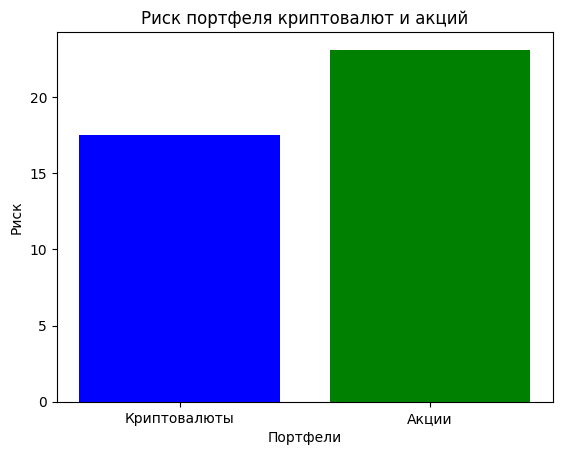

In [ ]:
# названия портфелей
portfolios = ['Криптовалюты', 'Акции']

# значения риска портфелей
risks = [risk_crypto**0.5, risk_stocks**0.5]

plt.bar(portfolios, risks, color=['blue', 'green'])
plt.xlabel('Портфели')
plt.ylabel('Риск')
plt.title('Риск портфеля криптовалют и акций')
plt.show()


# **Модель машинного обучения для портфелей**

In [ ]:
# 1. С помощью моделей машинного обучения построить прогноз доходностей портфелей на 2024 на год
# 2. Сравнить его с реальными данными

In [ ]:
equal_portfolio['Crypto Portfolio Returns'] = equal_portfolio['Price Change Crypto'].add(1).cumprod() - 1
equal_portfolio['Stocks Portfolio Returns'] = equal_portfolio['Price Change Stocks'].add(1).cumprod() - 1
equal_portfolio['Index Returns'] = equal_portfolio['Index Change'].add(1).cumprod() - 1


# Заполняем первое значение этого столбца нулем
# equal_portfolio.at[0, 'Crypto Portfolio Returns'] = 0
# equal_portfolio.at[0, 'Stocks Portfolio Returns'] = 0

# Выводим датафрейм с новым столбцом доходности портфеля из криптовалют
print(equal_portfolio)

            Price Change Crypto  Price Change Stocks  Index Change  \
Date                                                                 
2020-08-03             0.000000             0.000000      0.000000   
2020-08-04            -0.013486            -0.026090      0.003519   
2020-08-05             0.030230             0.108274      0.005231   
2020-08-06             0.009210             0.067908      0.009971   
2020-08-07            -0.026604            -0.026006     -0.008740   
...                         ...                  ...           ...   
2023-12-22             0.018815             0.073674      0.001945   
2023-12-26            -0.028046             0.000066      0.005443   
2023-12-27             0.153325             0.128124      0.001633   
2023-12-28             0.036326            -0.057633     -0.000268   
2023-12-29            -0.007216            -0.134259     -0.005551   

            Crypto Portfolio Returns  Stocks Portfolio Returns  Index Returns  
Date     

In [ ]:
equal_portfolio

,Price Change Crypto,Price Change Stocks,Index Change,Crypto Portfolio Returns,Stocks Portfolio Returns,Index Returns
Date,,,,,,
2020-08-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-08-04,-0.013486,-0.026090,0.003519,-0.013486,-0.026090,0.003519
2020-08-05,0.030230,0.108274,0.005231,0.016337,0.079359,0.008768
2020-08-06,0.009210,0.067908,0.009971,0.025697,0.152656,0.018827
2020-08-07,-0.026604,-0.026006,-0.008740,-0.001591,0.122681,0.009922
...,...,...,...,...,...,...
2023-12-22,0.018815,0.073674,0.001945,1.411822,5.977534,0.375149
2023-12-26,-0.028046,0.000066,0.005443,1.344180,5.977997,0.382633
2023-12-27,0.153325,0.128124,0.001633,1.703602,6.872046,0.384890


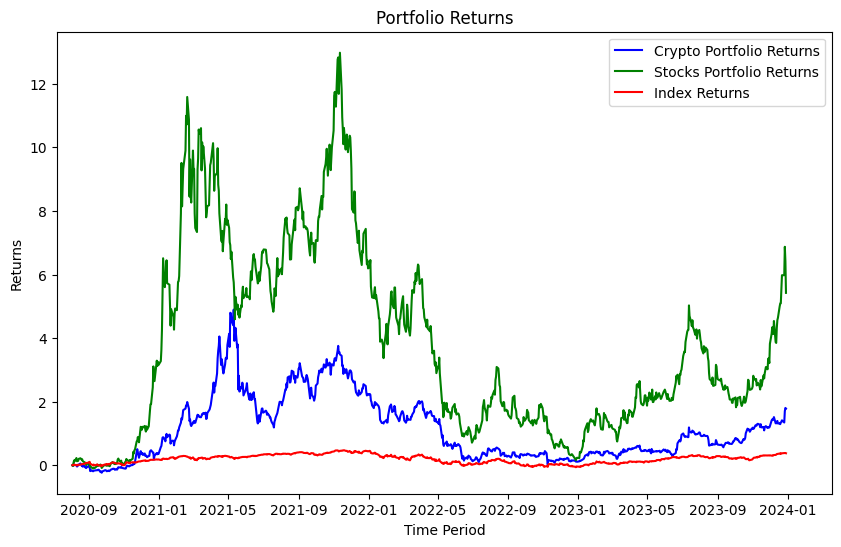

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(equal_portfolio['Crypto Portfolio Returns'], label='Crypto Portfolio Returns', color='blue')
plt.plot(equal_portfolio['Stocks Portfolio Returns'], label='Stocks Portfolio Returns', color='green')
plt.plot(equal_portfolio['Index Returns'], label='Index Returns', color='red')


# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()
plt.xlim(18450, 19800)  # Ограничение масштаба оси x

# Отображение графика
plt.show()

**Для портфеля криптовалют**

Для начала создадим новый датафрейм с данными за 2024 год (до июня)

In [ ]:
#полные данные цен на 2024 год (до июня)

crypto_data_2024 = yf.download(['BTC-USD', 'ETH-USD', 'XRP-USD','BCH-USD', 'BSV-USD'], start='2024-01-01', end='2024-06-01', interval='1d')
stocks_data_2024 = yf.download(['MSTR', 'MARA', 'RIOT', 'CLSK', 'HUT'], start='2024-01-01', end='2024-06-01', interval='1d')
NASDAQ_data_2024 = yf.download('^IXIC', start='2024-01-01', end='2024-06-01', interval='1d')

# Получаем список торговых дней из stocks_data_2024
stock_trading_days_2024 = stocks_data_2024.index

# Фильтруем crypto_data, оставляя только строки с торговыми днями из stocks_data
crypto_data_filtered_2024 = crypto_data_2024[crypto_data_2024.index.isin(stock_trading_days_2024)]


# print(crypto_data_filtered)
# Проверяем размер
print('Размеры новых данных:', len(crypto_data_filtered_2024), len(stock_trading_days_2024), len(NASDAQ_data_2024))

crypto_data_filtered_2024 = crypto_data_filtered_2024[[(    'Close', 'BCH-USD'),
            (    'Close', 'BSV-USD'),
            (    'Close', 'BTC-USD'),
            (    'Close', 'ETH-USD'),
            (    'Close', 'XRP-USD')]]

stocks_data_2024 = stocks_data_2024[[(    'Close', 'CLSK'),
            (    'Close',  'HUT'),
            (    'Close', 'MARA'),
            (    'Close', 'MSTR'),
            (    'Close', 'RIOT')]]

NASDAQ_data_2024 = NASDAQ_data_2024[['Close', 'Volume']]

#торговые дни на бирже 2024-2025 год

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed

Размеры новых данных: 105 105 105


In [ ]:
# Для криптовалютных данных
crypto_data_filtered_2024['Price Change', 'BCH-USD'] = (crypto_data_filtered_2024['Close', 'BCH-USD'] - crypto_data_filtered_2024['Close', 'BCH-USD'].shift(1)) / crypto_data_filtered_2024['Close', 'BCH-USD'].shift(1)
crypto_data_filtered_2024['Price Change', 'BSV-USD'] = (crypto_data_filtered_2024['Close', 'BSV-USD'] - crypto_data_filtered_2024['Close', 'BSV-USD'].shift(1)) / crypto_data_filtered_2024['Close', 'BSV-USD'].shift(1)
crypto_data_filtered_2024['Price Change', 'BTC-USD'] = (crypto_data_filtered_2024['Close', 'BTC-USD'] - crypto_data_filtered_2024['Close', 'BTC-USD'].shift(1)) / crypto_data_filtered_2024['Close', 'BTC-USD'].shift(1)
crypto_data_filtered_2024['Price Change', 'ETH-USD'] = (crypto_data_filtered_2024['Close', 'ETH-USD'] - crypto_data_filtered_2024['Close', 'ETH-USD'].shift(1)) / crypto_data_filtered_2024['Close', 'ETH-USD'].shift(1)
crypto_data_filtered_2024['Price Change', 'XRP-USD'] = (crypto_data_filtered_2024['Close', 'XRP-USD'] - crypto_data_filtered_2024['Close', 'XRP-USD'].shift(1)) / crypto_data_filtered_2024['Close', 'XRP-USD'].shift(1)

# Для акций
stocks_data_2024['Price Change', 'CLSK'] = (stocks_data_2024['Close', 'CLSK'] - stocks_data_2024['Close', 'CLSK'].shift(1)) / stocks_data_2024['Close', 'CLSK'].shift(1)
stocks_data_2024['Price Change', 'HUT'] = (stocks_data_2024['Close', 'HUT'] - stocks_data_2024['Close', 'HUT'].shift(1)) / stocks_data_2024['Close', 'HUT'].shift(1)
stocks_data_2024['Price Change', 'MARA'] = (stocks_data_2024['Close', 'MARA'] - stocks_data_2024['Close', 'MARA'].shift(1)) / stocks_data_2024['Close', 'MARA'].shift(1)
stocks_data_2024['Price Change', 'MSTR'] = (stocks_data_2024['Close', 'MSTR'] - stocks_data_2024['Close', 'MSTR'].shift(1)) / stocks_data_2024['Close', 'MSTR'].shift(1)
stocks_data_2024['Price Change', 'RIOT'] = (stocks_data_2024['Close', 'RIOT'] - stocks_data_2024['Close', 'RIOT'].shift(1)) / stocks_data_2024['Close', 'RIOT'].shift(1)

#Для индекса
NASDAQ_data_2024['Index Change'] = (NASDAQ_data_2024['Close'] - NASDAQ_data_2024['Close'].shift(1)) / NASDAQ_data_2024['Close'].shift(1)

# Заменить все NaN на 0 в crypto_data_filtered_2024
crypto_data_filtered_2024 = crypto_data_filtered_2024.fillna(0)

# Заменить все NaN на 0 в stocks_data
stocks_data_2024 = stocks_data_2024.fillna(0)

# Заменить все NaN на 0 в NASDAQ_data
NASDAQ_data_2024 = NASDAQ_data_2024.fillna(0)

<ipython-input-54-b52143d1c56c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NASDAQ_data_2024['Index Change'] = (NASDAQ_data_2024['Close'] - NASDAQ_data_2024['Close'].shift(1)) / NASDAQ_data_2024['Close'].shift(1)


In [ ]:
#т.к. доходность в 2024 году изначально не нулевая

crypto_last_return = equal_portfolio['Crypto Portfolio Returns'].iloc[-1]
stocks_last_return = equal_portfolio['Stocks Portfolio Returns'].iloc[-1]
index_last_return = equal_portfolio['Index Returns'].iloc[-1]

print("Последние значения по индексу:")
print("Crypto Portfolio Returns:", crypto_last_return)
print("Stocks Portfolio Returns:", stocks_last_return)
print("Index Returns:", index_last_return)

Последние значения по индексу:
Crypto Portfolio Returns: 1.7815971177236567
Stocks Portfolio Returns: 5.422375417910078
Index Returns: 0.3768343800022014


In [ ]:
# Создаем датафрейм для равновесных портфелей криптовалют и акций на 2024 год
equal_portfolio_2024 = pd.DataFrame()
equal_portfolio_2024['Price Change Crypto'] = 0.2 * crypto_data_filtered_2024['Price Change', 'BCH-USD'] + \
                                            0.2 * crypto_data_filtered_2024['Price Change', 'BSV-USD'] + \
                                            0.2 * crypto_data_filtered_2024['Price Change', 'BTC-USD'] + \
                                            0.2 * crypto_data_filtered_2024['Price Change', 'ETH-USD'] + \
                                            0.2 * crypto_data_filtered_2024['Price Change', 'XRP-USD']

# Создаем датафрейм для равновесного портфеля акций
equal_portfolio_2024['Price Change Stocks'] = 0.2 * stocks_data_2024['Price Change', 'CLSK'] + \
                                            0.2 * stocks_data_2024['Price Change', 'HUT'] + \
                                            0.2 * stocks_data_2024['Price Change', 'MARA'] + \
                                            0.2 * stocks_data_2024['Price Change', 'MSTR'] + \
                                            0.2 * stocks_data_2024['Price Change', 'RIOT']

equal_portfolio_2024['Index Change']  = NASDAQ_data_2024['Index Change']

equal_portfolio_2024['Crypto Portfolio Returns'] = crypto_last_return + equal_portfolio_2024['Price Change Crypto'].add(1).cumprod() - 1
equal_portfolio_2024['Stocks Portfolio Returns'] = stocks_last_return + equal_portfolio_2024['Price Change Stocks'].add(1).cumprod() - 1
equal_portfolio_2024['Index Returns'] = index_last_return + equal_portfolio_2024['Index Change'].add(1).cumprod() - 1


#для упрощения созданим колонку дат
equal_portfolio_2024['Date'] = equal_portfolio_2024.index


In [ ]:
equal_portfolio_2024

,Price Change Crypto,Price Change Stocks,Index Change,Crypto Portfolio Returns,Stocks Portfolio Returns,Index Returns,Date
Date,,,,,,,
2024-01-02,0.000000,0.000000,0.000000,1.781597,5.422375,0.376834,2024-01-02
2024-01-03,-0.078617,-0.026127,-0.011766,1.702980,5.396248,0.365069,2024-01-03
2024-01-04,0.014863,0.049734,-0.005613,1.716675,5.444683,0.359522,2024-01-04
2024-01-05,-0.007472,-0.057178,0.000949,1.709688,5.386230,0.360454,2024-01-05
2024-01-08,0.052341,0.032625,0.022012,1.758265,5.417675,0.382105,2024-01-08
...,...,...,...,...,...,...,...
2024-05-24,0.000621,0.053313,0.011040,2.031161,5.636833,0.522768,2024-05-24
2024-05-28,-0.008466,-0.007275,0.005856,2.020582,5.627998,0.529479,2024-05-28
2024-05-29,-0.011620,-0.031163,-0.005834,2.006184,5.590427,0.522754,2024-05-29


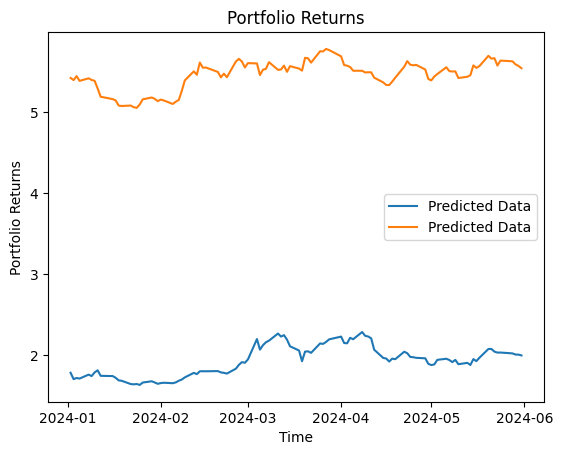

In [ ]:
plt.plot(equal_portfolio_2024['Date'], equal_portfolio_2024['Crypto Portfolio Returns'], label='Predicted Data')
plt.plot(equal_portfolio_2024['Date'], equal_portfolio_2024['Stocks Portfolio Returns'], label='Predicted Data')
plt.legend()
plt.title('Portfolio Returns')
plt.xlabel('Time')
plt.ylabel('Portfolio Returns')
plt.show()

**Обучим модель на данных за 2020-2023 год и сделаем прогноз а 2024 год**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/stat

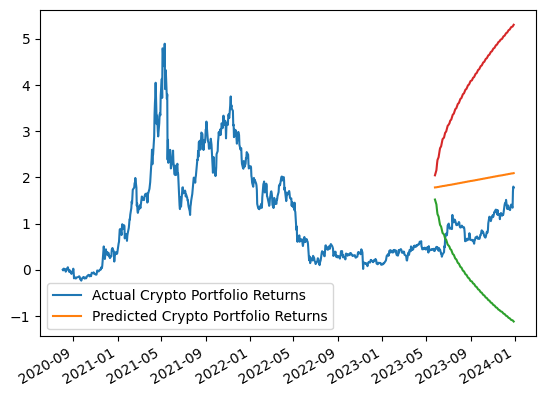

In [ ]:
# import statsmodels.api as sm
# import pandas_datareader.data as web

# df = equal_portfolio['Crypto Portfolio Returns']
# total = len(df)
# aaa = 150
# hist = total - aaa

# model = sm.tsa.statespace.SARIMAX(df, trend='c', order=(0,1,0))
# fitted = model.fit(disp=False)

# result = fitted.forecast(aaa, alpha = 0.05)
# conf_ins = fitted.get_forecast(aaa).summary_frame()
# ind = np.arange(total)

# fig, ax = plt.subplots()
# ax.plot(df.index, df, label='Actual Crypto Portfolio Returns')
# ax.plot(df.index[hist:], result, label='Predicted Crypto Portfolio Returns')
# ax.plot(df.index[hist:], conf_ins['mean_ci_lower'])
# ax.plot(df.index[hist:], conf_ins['mean_ci_upper'])
# ax.legend()
# fig.autofmt_xdate()
# plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


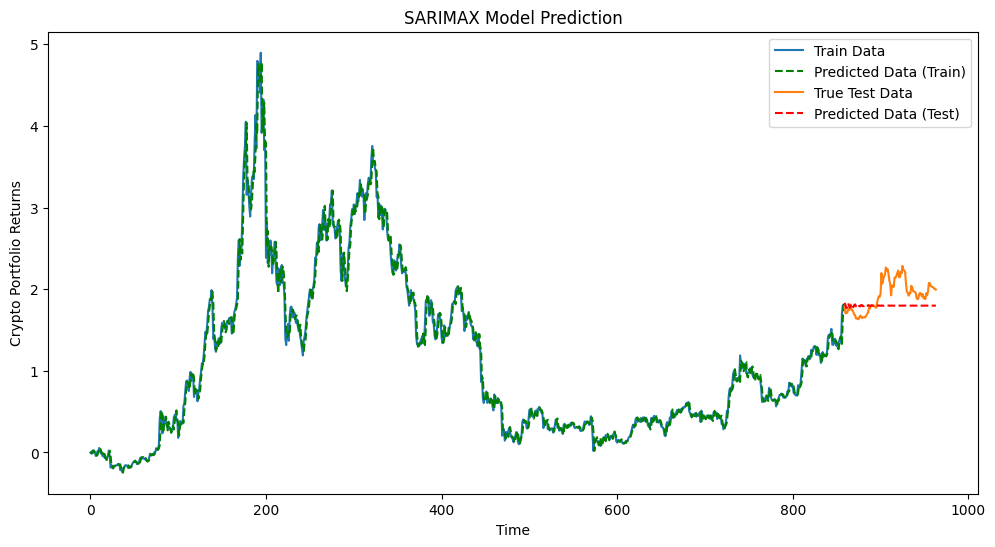

In [ ]:
# Заданные параметры
x_train = np.arange(len(equal_portfolio['Crypto Portfolio Returns']))
x_test = np.arange(len(equal_portfolio['Crypto Portfolio Returns']), len(equal_portfolio['Crypto Portfolio Returns']) + len(equal_portfolio_2024['Crypto Portfolio Returns']))
y_train = equal_portfolio['Crypto Portfolio Returns']
y_test = equal_portfolio_2024['Crypto Portfolio Returns']

# Создание и обучение модели SARIMAX
model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
fitted_model = model.fit()

# Предсказание с использованием тестовых данных
y_pred_train_SARIMAX = fitted_model.predict(start=min(x_test), end=max(x_test))
y_pred_train_SARIMAX_train_data = fitted_model.predict(start=min(x_train), end=max(x_train))

# Вывод графика
plt.figure(figsize=(12, 6))
plt.plot(x_train, y_train, label='Train Data')
plt.plot(x_train, y_pred_train_SARIMAX_train_data, label='Predicted Data (Train)', linestyle='dashed', color='green')
plt.plot(x_test, y_test, label='True Test Data')
plt.plot(x_test, y_pred_train_SARIMAX, label='Predicted Data (Test)', linestyle='dashed', color='red')
plt.legend()
plt.title('SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Crypto Portfolio Returns')
plt.show()


В модели ARIMAX (Autoregressive Integrated Moving Average with Exogenous Variables) параметры order и seasonalorder отвечают за порядок авторегрессии, разности и скользящего среднего в модели ARIMA, а также за порядок сезонности соответственно.

В параметре order=(p, d, q):
- p - порядок авторегрессии (AR),
- d - порядок дифференцирования (I),
- q - порядок скользящего среднего (MA).

В параметре seasonalorder=(P, D, Q, s):
- P - порядок сезонной авторегрессии,
- D - порядок сезонного дифференцирования,
- Q - порядок сезонного скользящего среднего,
- s - период сезонности.

In [ ]:
pip install pmdarima


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-1053.742, Time=17.36 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1011.886, Time=0.58 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1041.760, Time=2.00 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1040.818, Time=6.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1013.679, Time=0.27 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-1057.693, Time=16.68 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-1049.541, Time=4.67 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-1053.819, Time=17.01 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-1054.799, Time=9.22 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-1054.696, Time=22.83 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=-1047.550, Time=6.26 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=-1046.161, Time=6.88 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=8.03 sec
 ARIMA(2,1,3)(0,0,1)[12] intercept   : AIC=-1053.454, Time=5.80 sec
 ARIMA(

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


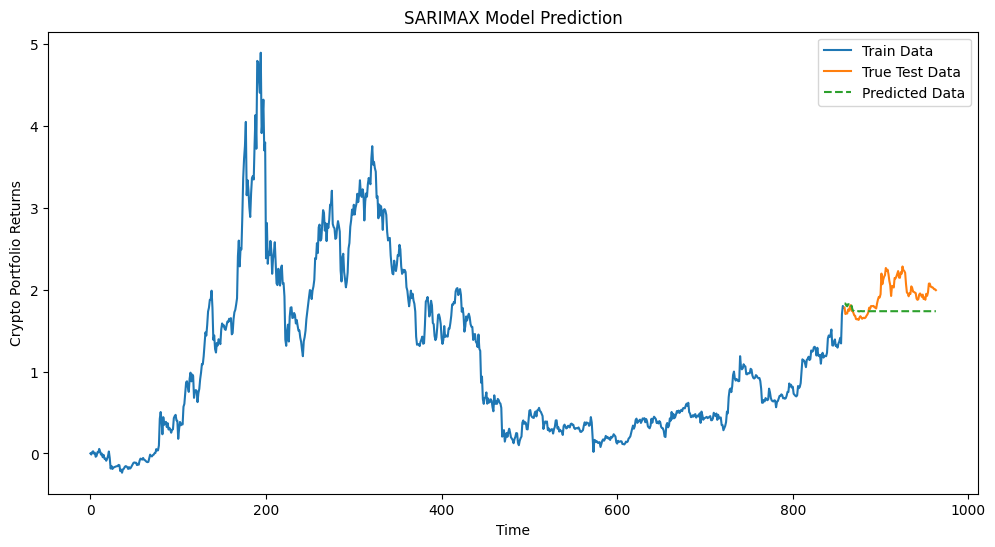

In [ ]:
from pmdarima import auto_arima

# Подбор лучших параметров для модели SARIMAX
auto_model = auto_arima(y_train, seasonal=True, m=12, max_order=None, trace=True)

# Извлечение лучших параметров
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# Создание и обучение модели SARIMAX с найденными параметрами
model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit()

# Предсказание с использованием тестовых данных
predictions = fitted_model.predict(start=min(x_test), end=max(x_test))

# Вывод графика
plt.figure(figsize=(12, 6))
plt.plot(x_train, y_train, label='Train Data')
plt.plot(x_test, y_test, label='True Test Data')
plt.plot(x_test, predictions, label='Predicted Data', linestyle='dashed')
plt.legend()
plt.title('SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Crypto Portfolio Returns')
plt.show()


Лучший результат: (2,1,2)


# **Регрессии для портфелей** 2020-2024

**Для портфеля криптовалют**

In [ ]:
equal_portfolio['Date'] = equal_portfolio.index


In [ ]:
# Создание признаков и целевой переменной для обучения
x_train = np.arange(len(equal_portfolio['Crypto Portfolio Returns']))
y_train = equal_portfolio['Crypto Portfolio Returns']
y_test = equal_portfolio_2024['Crypto Portfolio Returns']

# Для расширения прогноза на equal_portfolio_2024['Crypto Portfolio Returns']
x_test = np.arange(len(equal_portfolio['Crypto Portfolio Returns']), len(equal_portfolio['Crypto Portfolio Returns']) + len(equal_portfolio_2024['Crypto Portfolio Returns']))

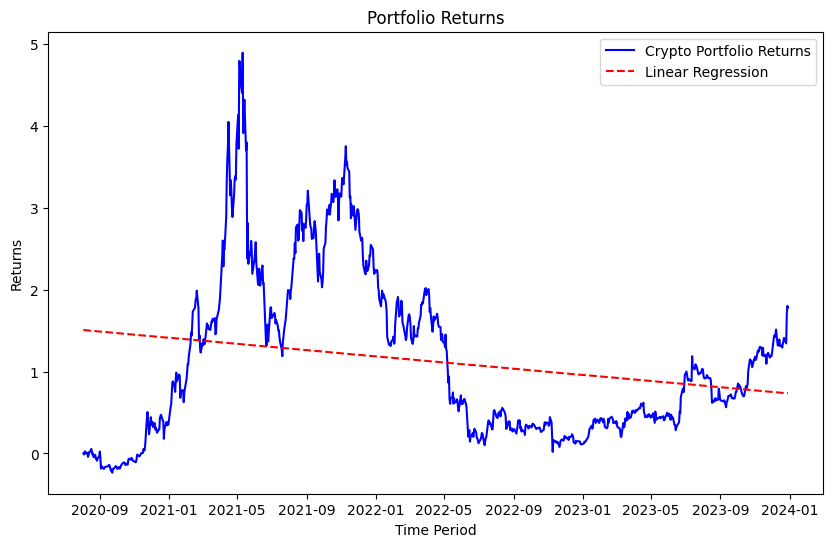

In [ ]:
y = equal_portfolio['Crypto Portfolio Returns']

# Подгоняем линейную регрессию
p = np.poly1d(np.polyfit(x_train, y_train, 1))

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y_train, label='Crypto Portfolio Returns', color='blue')

# График линейной регрессии
plt.plot(equal_portfolio['Date'], p(x_train), label='Linear Regression', color='red', linestyle='dashed')

# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()
# plt.xlim(18450, 19800)  # Ограничение масштаба оси x

# Отображение графика
plt.show()

In [ ]:
# расчет R-квадрат
r_squared = r2_score(y, p(x_train))
print("R-squared value: {:.2f}".format(r_squared))

R-squared value: 0.05


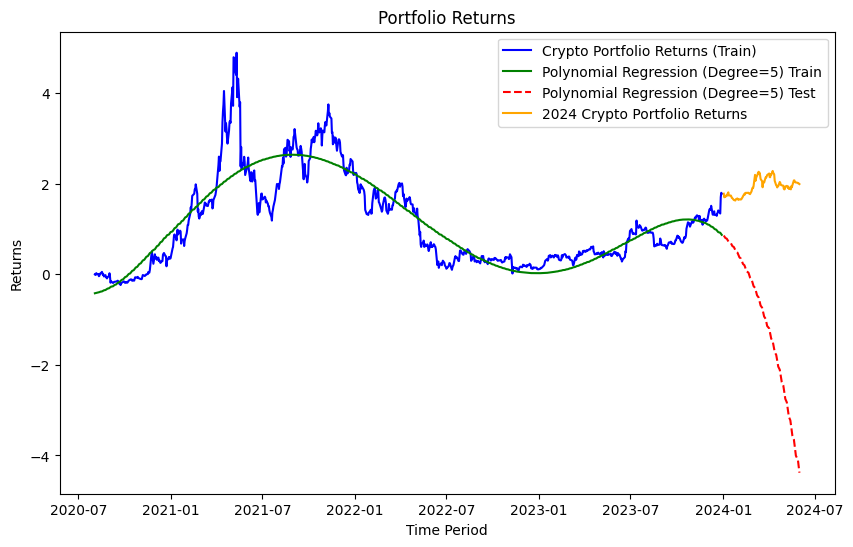

In [ ]:
# Преобразование x_train в полиномиальные признаки степени 5
poly_features = PolynomialFeatures(degree=5)
X_poly_train = poly_features.fit_transform(x_train[:, np.newaxis])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Предсказание значений на обучающих данных
y_pred_train_p5 = model.predict(X_poly_train)


# Преобразование x_test в полиномиальные признаки степени 5
X_poly_test = poly_features.transform(x_test[:, np.newaxis])

# Предсказание значений для новых данных
y_pred_test_p5 = model.predict(X_poly_test)

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y_train, label='Crypto Portfolio Returns (Train)', color='blue')

# График полиномиальной регрессии на обучающих данных
plt.plot(equal_portfolio['Date'], y_pred_train_p5, label='Polynomial Regression (Degree=5) Train', color='green')

# График полиномиальной регрессии на тестовых данных (прогноз)
plt.plot(equal_portfolio_2024['Date'], y_pred_test_p5, label='Polynomial Regression (Degree=5) Test', color='red', linestyle='dashed')

# График реальных Crypto Portfolio Returns в 2024
plt.plot(equal_portfolio_2024['Date'], y_test, label='2024 Crypto Portfolio Returns', color='orange')


# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()


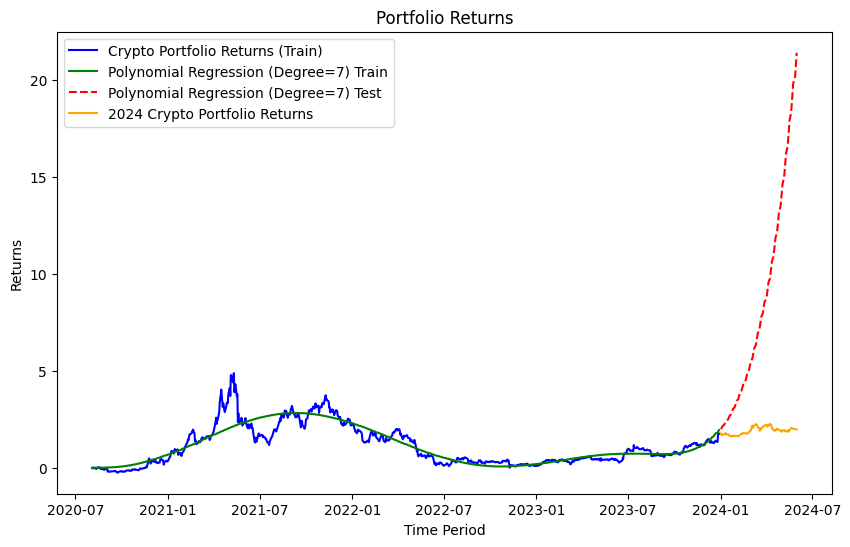

In [ ]:
# Преобразование x_train в полиномиальные признаки степени 7
poly_features = PolynomialFeatures(degree=7)
X_poly_train = poly_features.fit_transform(x_train[:, np.newaxis])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly_train, y_train)

# Предсказание значений на обучающих данных
y_pred_train_p7 = model.predict(X_poly_train)

# Для расширения прогноза на equal_portfolio_2024['Crypto Portfolio Returns']
# x_test = np.arange(len(equal_portfolio_2024['Crypto Portfolio Returns']))
x_test = np.arange(len(equal_portfolio['Crypto Portfolio Returns']), len(equal_portfolio['Crypto Portfolio Returns']) + len(equal_portfolio_2024['Crypto Portfolio Returns']))


# Преобразование x_test в полиномиальные признаки степени 7
X_poly_test = poly_features.transform(x_test[:, np.newaxis])

# Предсказание значений для новых данных
y_pred_test_p7 = model.predict(X_poly_test)

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y_train, label='Crypto Portfolio Returns (Train)', color='blue')

# График полиномиальной регрессии на обучающих данных
plt.plot(equal_portfolio['Date'], y_pred_train_p7, label='Polynomial Regression (Degree=7) Train', color='green')

# График полиномиальной регрессии на тестовых данных (прогноз)
plt.plot(equal_portfolio_2024['Date'], y_pred_test_p7, label='Polynomial Regression (Degree=7) Test', color='red', linestyle='dashed')

# График реальных Crypto Portfolio Returns в 2024
plt.plot(equal_portfolio_2024['Date'], y_test, label='2024 Crypto Portfolio Returns', color='orange')

# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()


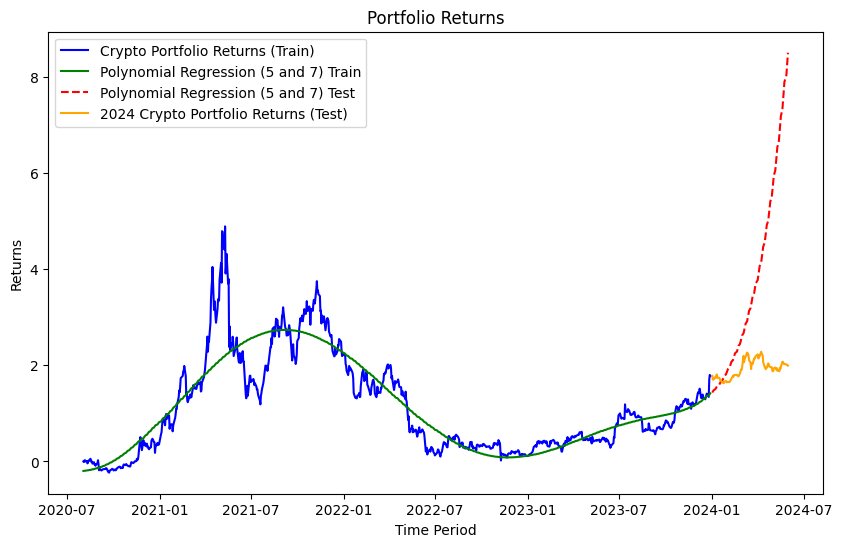

In [ ]:
plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y_train, label='Crypto Portfolio Returns (Train)', color='blue')

# График полиномиальной регрессии на обучающих данных
plt.plot(equal_portfolio['Date'], (y_pred_train_p5+y_pred_train_p7)*0.5, label='Polynomial Regression (5 and 7) Train', color='green')

# График полиномиальной регрессии на тестовых данных (прогноз)
plt.plot(equal_portfolio_2024['Date'], (y_pred_test_p7+y_pred_test_p5)*0.5, label='Polynomial Regression (5 and 7) Test', color='red', linestyle='dashed')

# График реальных Crypto Portfolio Returns в 2024
plt.plot(equal_portfolio_2024['Date'], y_test, label='2024 Crypto Portfolio Returns (Test)', color='orange')

# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()

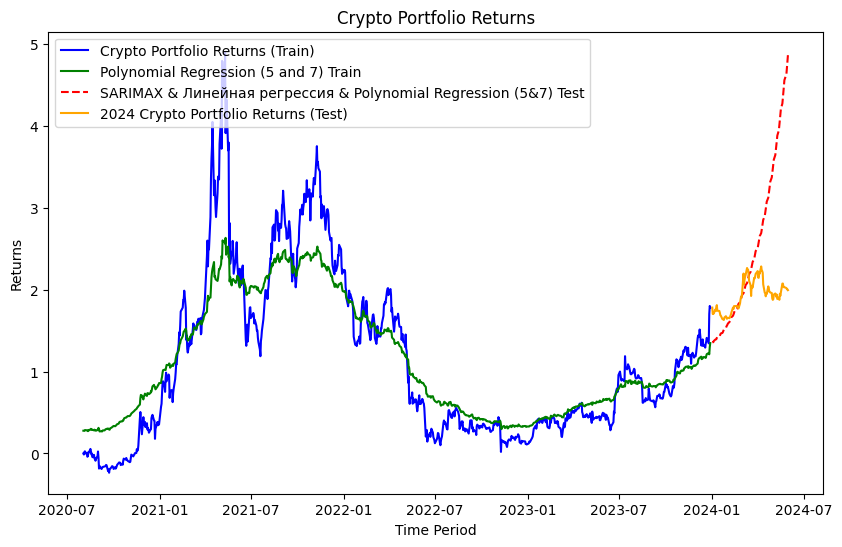

In [ ]:
plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y_train, label='Crypto Portfolio Returns (Train)', color='blue')

# График полиномиальной регрессии на обучающих данных
plt.plot(equal_portfolio['Date'], (p(x_train)+y_pred_train_SARIMAX_train_data+y_pred_train_p5+y_pred_train_p7)*(1/4), label='Polynomial Regression (5 and 7) Train', color='green')

# Графики прогнозируемой доходности на тестовых данных
plt.plot(equal_portfolio_2024['Date'], (p(x_test)+y_pred_train_SARIMAX+y_pred_test_p7+y_pred_test_p5)*(1/4), label='SARIMAX & Линейная регрессия & Polynomial Regression (5&7) Test', color='red', linestyle='dashed')

# График реальных Crypto Portfolio Returns в 2024
plt.plot(equal_portfolio_2024['Date'], y_test, label='2024 Crypto Portfolio Returns (Test)', color='orange')

# Добавление заголовка и меток на график
plt.title('Crypto Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()

In [ ]:
# расчет R-квадрат для совокупного прогноза
r_squared = r2_score(y_train, (p(x_train)+y_pred_train_SARIMAX_train_data+y_pred_train_p5+y_pred_train_p7)*(1/4))
print("R-squared value (2020-2023 train): {:.2f}".format(r_squared))

r_squared = r2_score(y_test,  (p(x_test)+y_pred_train_SARIMAX+y_pred_test_p7+y_pred_test_p5)*(1/4))
print("R-squared value (2024 test): {:.2f}".format(r_squared))


R-squared value (2020-2023 train): 0.83
R-squared value (2024 test): -34.97


**Вывод:**

Четыре выбранных модели хорошо работают на выборке для обучения, но совсем не подходят для прогноза

**Для портфеля акций**

In [ ]:
# Создание признаков и целевой переменной для обучения
x_train = np.arange(len(equal_portfolio['Stocks Portfolio Returns']))
y_train = equal_portfolio['Stocks Portfolio Returns']
y_test = equal_portfolio_2024['Stocks Portfolio Returns']

# Для расширения прогноза на equal_portfolio_2024['Crypto Portfolio Returns']
x_test = np.arange(len(equal_portfolio['Stocks Portfolio Returns']), len(equal_portfolio['Stocks Portfolio Returns']) + len(equal_portfolio_2024['Stocks Portfolio Returns']))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

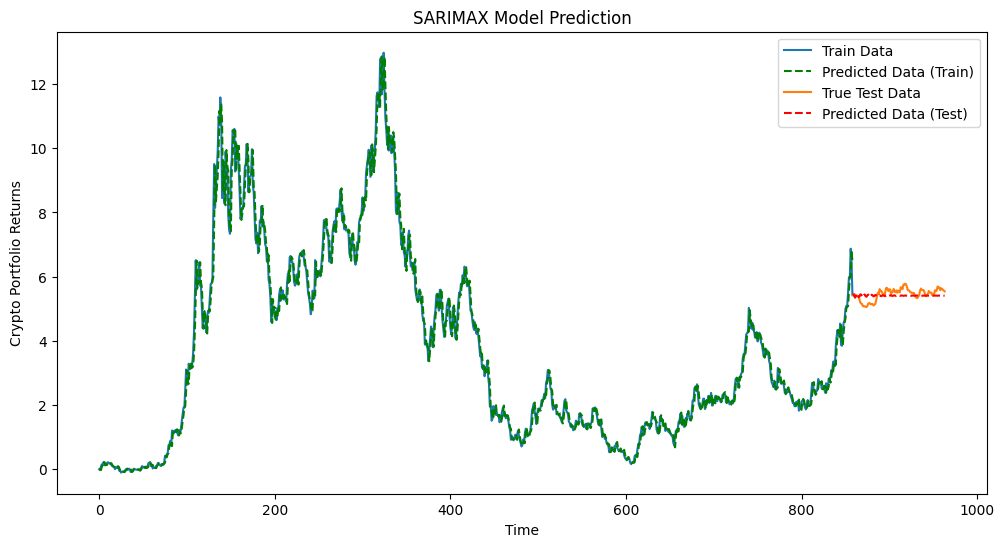

In [ ]:
# Создание и обучение модели SARIMAX
model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(0, 0, 0, 0))
fitted_model = model.fit()

# Предсказание с использованием тестовых данных
y_pred_train_SARIMAX = fitted_model.predict(start=min(x_test), end=max(x_test))
y_pred_train_SARIMAX_train_data = fitted_model.predict(start=min(x_train), end=max(x_train))

# Вывод графика
plt.figure(figsize=(12, 6))
plt.plot(x_train, y_train, label='Train Data')
plt.plot(x_train, y_pred_train_SARIMAX_train_data, label='Predicted Data (Train)', linestyle='dashed', color='green')
plt.plot(x_test, y_test, label='True Test Data')
plt.plot(x_test, y_pred_train_SARIMAX, label='Predicted Data (Test)', linestyle='dashed', color='red')
plt.legend()
plt.title('SARIMAX Model Prediction')
plt.xlabel('Time')
plt.ylabel('Crypto Portfolio Returns')
plt.show()


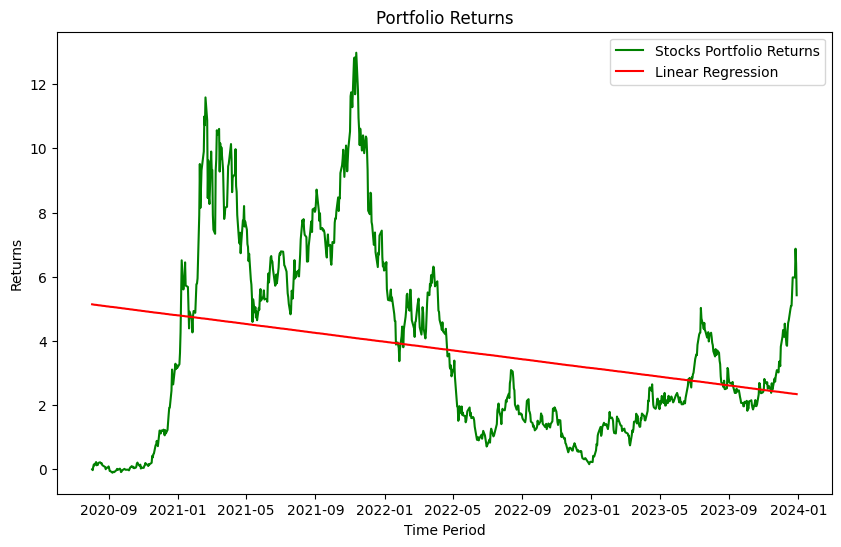

In [ ]:
# Выделяем переменные x и y для линейной регрессии
x = np.arange(len(equal_portfolio['Stocks Portfolio Returns']))
y = equal_portfolio['Stocks Portfolio Returns']

# Подгоняем линейную регрессию
p = np.poly1d(np.polyfit(x, y, 1))

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y, label='Stocks Portfolio Returns', color='green')

# График линейной регрессии
plt.plot(equal_portfolio['Date'], p(x), label='Linear Regression', color='red')

# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()
# plt.xlim(18450, 19800)  # Ограничение масштаба оси x

# Отображение графика
plt.show()

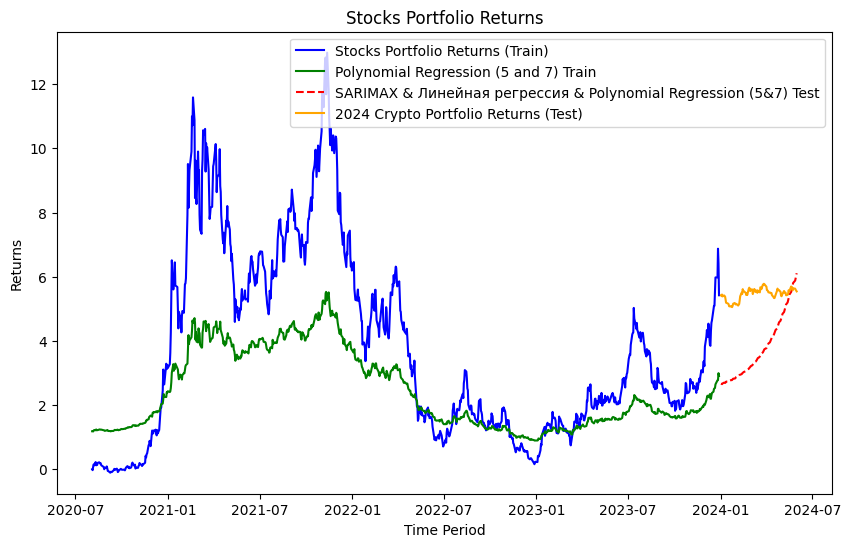

In [ ]:
plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y_train, label='Stocks Portfolio Returns (Train)', color='blue')

# График полиномиальной регрессии на обучающих данных
plt.plot(equal_portfolio['Date'], (p(x_train)+y_pred_train_SARIMAX_train_data+y_pred_train_p5+y_pred_train_p7)*(1/4), label='Polynomial Regression (5 and 7) Train', color='green')

# Графики прогнозируемой доходности на тестовых данных
plt.plot(equal_portfolio_2024['Date'], (p(x_test)+y_pred_train_SARIMAX+y_pred_test_p7+y_pred_test_p5)*(1/4), label='SARIMAX & Линейная регрессия & Polynomial Regression (5&7) Test', color='red', linestyle='dashed')

# График реальных Crypto Portfolio Returns в 2024
plt.plot(equal_portfolio_2024['Date'], y_test, label='2024 Crypto Portfolio Returns (Test)', color='orange')

# Добавление заголовка и меток на график
plt.title('Stocks Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()

In [ ]:
# расчет R-квадрат для совокупного прогноза
r_squared = r2_score(y_train, (p(x_train)+y_pred_train_SARIMAX_train_data+y_pred_train_p5+y_pred_train_p7)*(1/4))
print("R-squared value (2020-2023 train): {:.2f}".format(r_squared))

r_squared = r2_score(y_test,  (p(x_test)+y_pred_train_SARIMAX+y_pred_test_p7+y_pred_test_p5)*(1/4))
print("R-squared value (2024 test): {:.2f}".format(r_squared))

R-squared value (2020-2023 train): 0.43
R-squared value (2024 test): -110.27


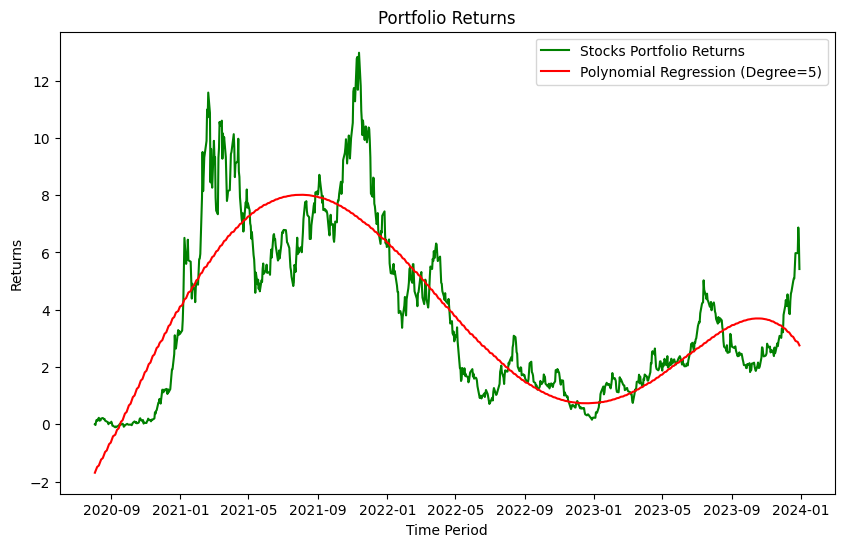

In [ ]:
# Преобразование x в полиномиальные признаки степени 5
poly_features = PolynomialFeatures(degree=5)
X_poly = poly_features.fit_transform(x[:, np.newaxis])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly, y)

# Предсказание значений
y_pred = model.predict(X_poly)

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y, label='Stocks Portfolio Returns', color='green')

# График полиномиальной регрессии
plt.plot(equal_portfolio['Date'], y_pred, label='Polynomial Regression (Degree=5)', color='red')

# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()


In [ ]:
# расчет R-квадрат
r_squared = r2_score(y, y_pred)
print("R-squared value: {:.2f}".format(r_squared))


R-squared value: 0.74


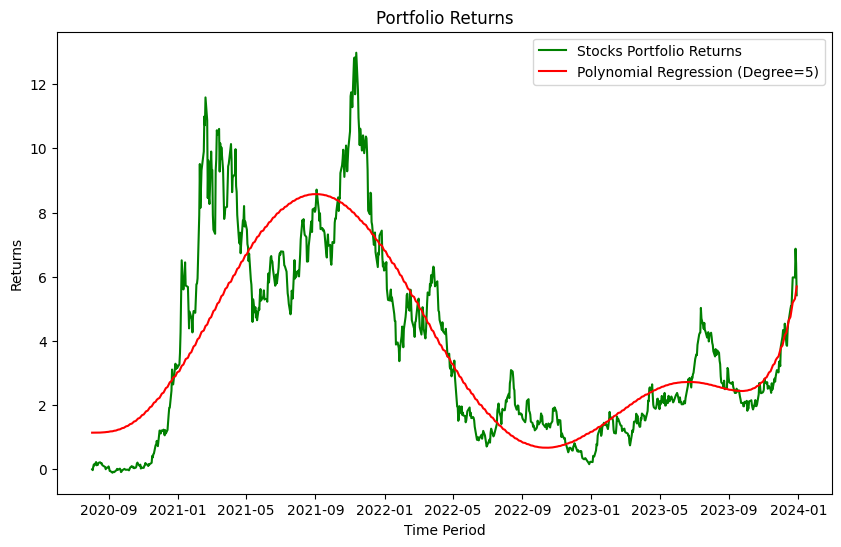

In [ ]:
poly_features = PolynomialFeatures(degree=7)
X_poly = poly_features.fit_transform(x[:, np.newaxis])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly, y)

# Предсказание значений
y_pred = model.predict(X_poly)

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y, label='Stocks Portfolio Returns', color='green')

# График полиномиальной регрессии
plt.plot(equal_portfolio['Date'], y_pred, label='Polynomial Regression (Degree=5)', color='red')

# Добавление заголовка и меток на график
plt.title('Portfolio Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()


In [ ]:
# расчет R-квадрат
r_squared = r2_score(y, y_pred)
print("R-squared value: {:.2f}".format(r_squared))


R-squared value: 0.72


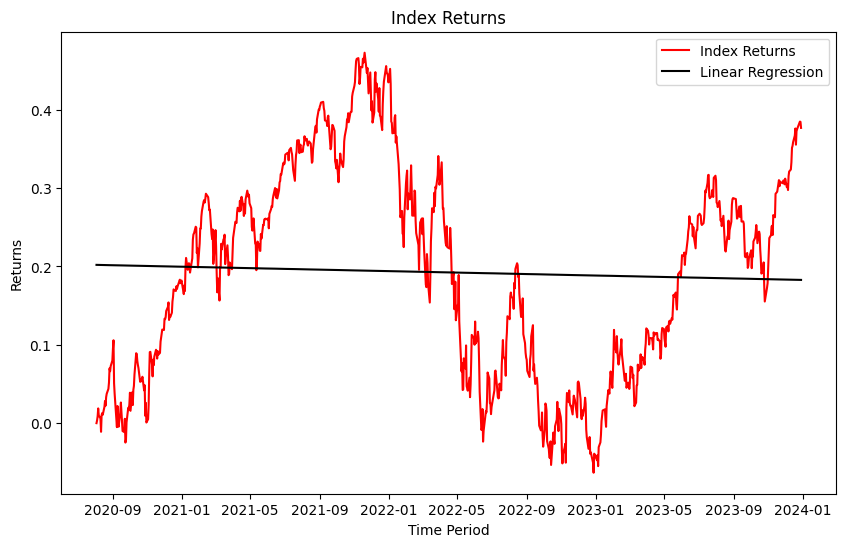

In [ ]:
# Выделяем переменные x и y для линейной регрессии
x = np.arange(len(equal_portfolio['Index Returns']))
y = equal_portfolio['Index Returns']

# Подгоняем линейную регрессию
p = np.poly1d(np.polyfit(x, y, 1))

plt.figure(figsize=(10, 6))

# График данных Index Returns
plt.plot(equal_portfolio['Date'], y, label='Index Returns', color='red')

# График линейной регрессии
plt.plot(equal_portfolio['Date'], p(x), label='Linear Regression', color='black')

# Добавление заголовка и меток на график
plt.title('Index Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()
# plt.xlim(18450, 19800)  # Ограничение масштаба оси x

# Отображение графика
plt.show()

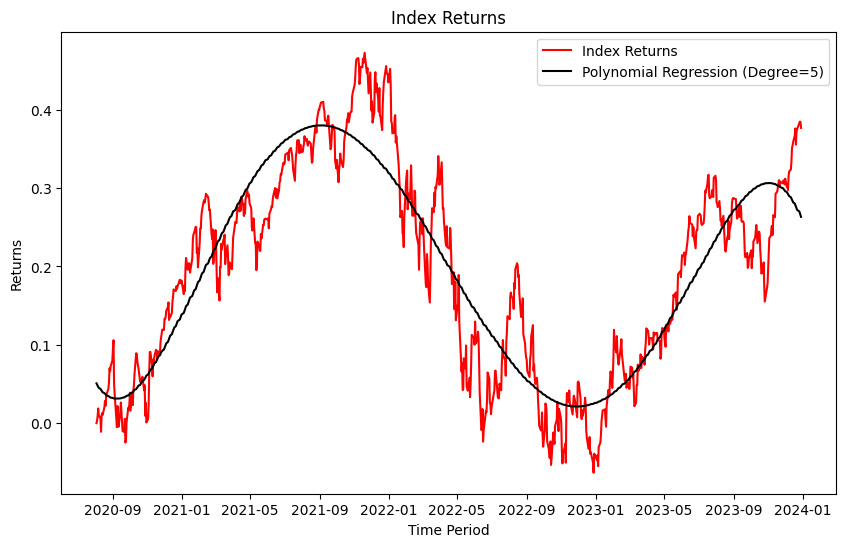

In [ ]:
# Преобразование x в полиномиальные признаки степени 5
poly_features = PolynomialFeatures(degree=5)
X_poly = poly_features.fit_transform(x[:, np.newaxis])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly, y)

# Предсказание значений
y_pred = model.predict(X_poly)

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y, label='Index Returns', color='red')

# График полиномиальной регрессии
plt.plot(equal_portfolio['Date'], y_pred, label='Polynomial Regression (Degree=5)', color='black')

# Добавление заголовка и меток на график
plt.title('Index Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()


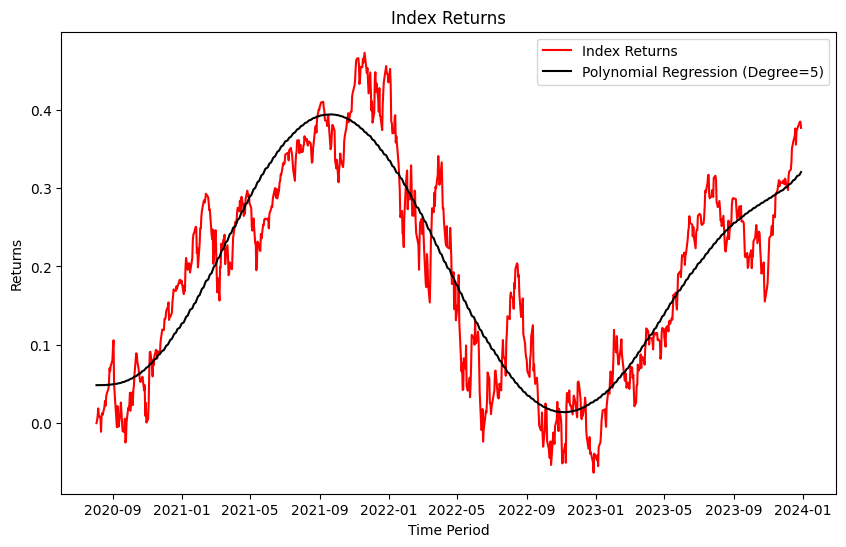

In [ ]:
# Преобразование x в полиномиальные признаки степени 7
poly_features = PolynomialFeatures(degree=7)
X_poly = poly_features.fit_transform(x[:, np.newaxis])

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_poly, y)

# Предсказание значений
y_pred = model.predict(X_poly)

plt.figure(figsize=(10, 6))

# График данных Crypto Portfolio Returns
plt.plot(equal_portfolio['Date'], y, label='Index Returns', color='red')

# График полиномиальной регрессии
plt.plot(equal_portfolio['Date'], y_pred, label='Polynomial Regression (Degree=5)', color='black')

# Добавление заголовка и меток на график
plt.title('Index Returns')
plt.xlabel('Time Period')
plt.ylabel('Returns')
plt.legend()

# Отображение графика
plt.show()


In [ ]:
# # Подгонка линейной регрессии к каждой из колонок
# x = np.arange(len(equal_portfolio))  # Создание массива значений x от 0 до количества строк в данных
# regression_crypto = np.polyfit(x, equal_portfolio['Crypto Portfolio Returns'], 1)  # Линейная регрессия для 'Crypto Portfolio Returns'
# regression_stocks = np.polyfit(x, equal_portfolio['Stocks Portfolio Returns'], 1)  # Линейная регрессия для 'Stocks Portfolio Returns'
# regression_index = np.polyfit(x, equal_portfolio['Index Returns'], 1)  # Линейная регрессия для 'Index Returns'

# # Построение графиков линейной регрессии
# plt.plot(x, np.polyval(regression_crypto, x), linestyle='dashed', color='blue', label='Crypto Regression')
# plt.plot(x, np.polyval(regression_stocks, x), linestyle='dashed', color='green', label='Stocks Regression')
# plt.plot(x, np.polyval(regression_index, x), linestyle='dashed', color='red', label='Index Regression')

# # Обновление легенды
# plt.legend()

# # Отображение обновленного графика
# plt.show()
